In [1]:
import numpy as np
import dataset_loader
from pathlib import Path
import matplotlib.pyplot as plt

import similarity
from midi import MIDIUnitSequence
import csv

from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
ROOT_PATH="../../sabana/dataset/asap-dataset"
# ROOT_PATH = "../dataset/newbie-dataset"

In [3]:
SLICE_DURATION = 5 # sec
EXPANSION_RATE = 1.5
NUM_SAMPLES = 10
QUEUE_SIZE = 8
NUM_MIDI_KEYS = 128
ONSET_WEIGHT = 10
SETTLE_FRAME = 10

In [4]:
def plot_matrix(name, matrix, head=None, tail=None):
    plt.figure("name", figsize=(16, 3))
    plt.imshow(matrix, cmap="gray", aspect="auto", origin="lower", interpolation="nearest")
    if head:
        plt.plot([head, head], [0, 128])
    if tail:
        plt.plot([tail, tail], [0, 128])
    plt.title(name)
    plt.ylabel("%d Pitches" % matrix.shape[0])
    plt.xlabel("%d Spectrogram Frames" % matrix.shape[1])
    plt.show()

def process_decay(midi_matrix):
    midi_matrix = np.reshape(midi_matrix, [NUM_MIDI_KEYS, -1]).T
    geo_ratio = (0.1)**(1/SETTLE_FRAME)
    for frame_idx in range(len(midi_matrix)):
        midi_unit_sequence = MIDIUnitSequence()
        for midi_key in range(NUM_MIDI_KEYS):
            if midi_matrix[frame_idx, midi_key] <= 0:
                continue
            elif frame_idx > 0:
                prev_velocity = midi_matrix[frame_idx - 1, midi_key]
                if prev_velocity > 0:
                    velocity = prev_velocity * geo_ratio
                else:
                    velocity = ONSET_WEIGHT
            else:
                velocity = ONSET_WEIGHT
            midi_matrix[frame_idx, midi_key] = velocity

  0%|          | 0/10 [00:00<?, ?it/s]

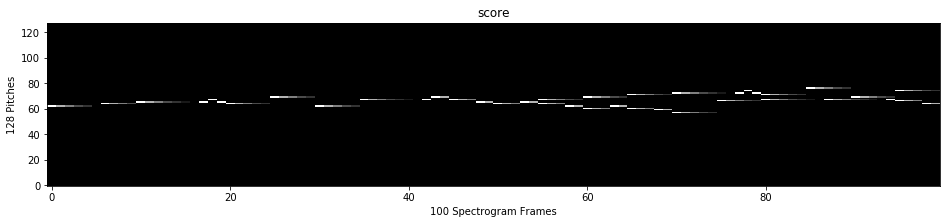

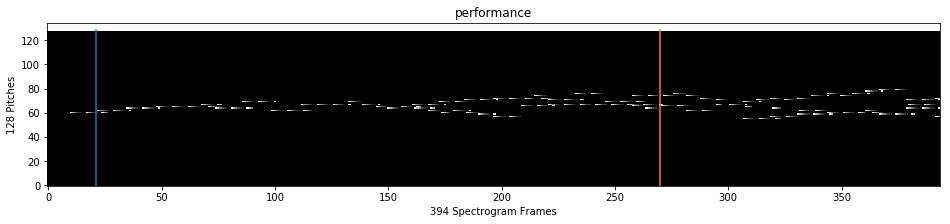

 10%|█         | 1/10 [00:00<00:06,  1.36it/s]

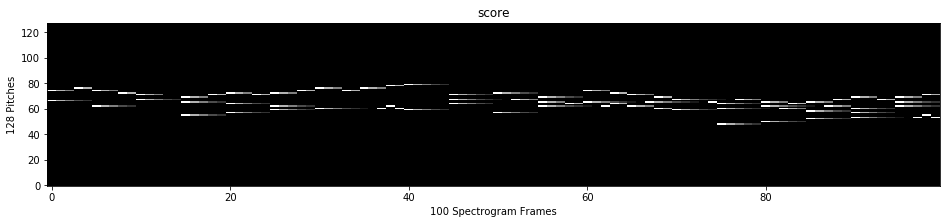

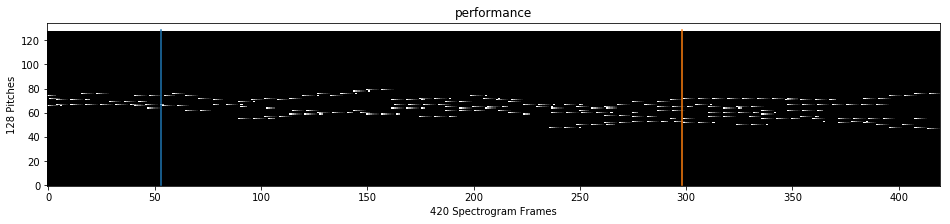

 20%|██        | 2/10 [00:01<00:04,  1.81it/s]

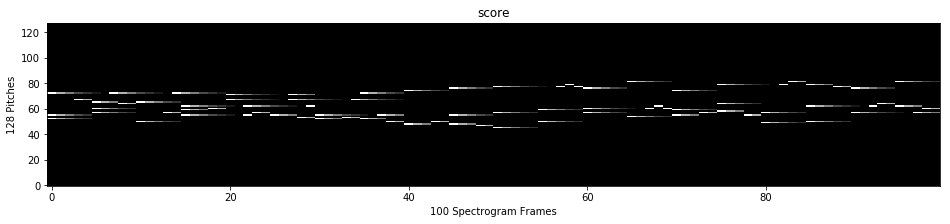

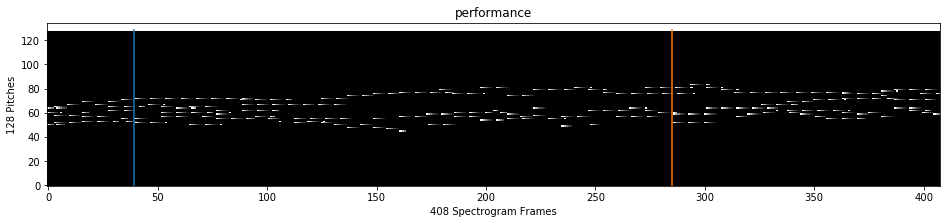

 30%|███       | 3/10 [00:01<00:03,  1.99it/s]

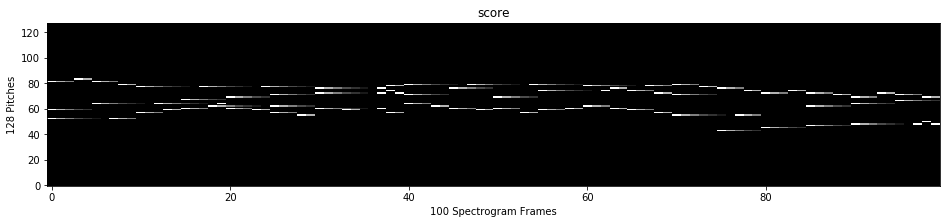

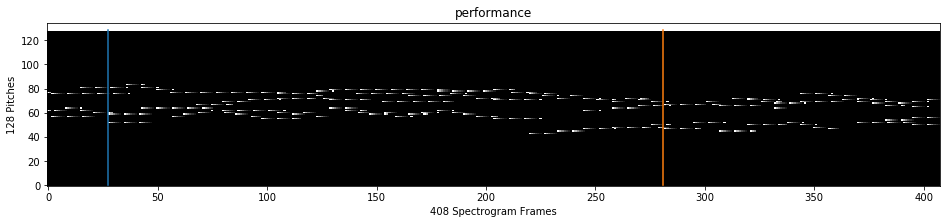

 40%|████      | 4/10 [00:02<00:03,  1.98it/s]

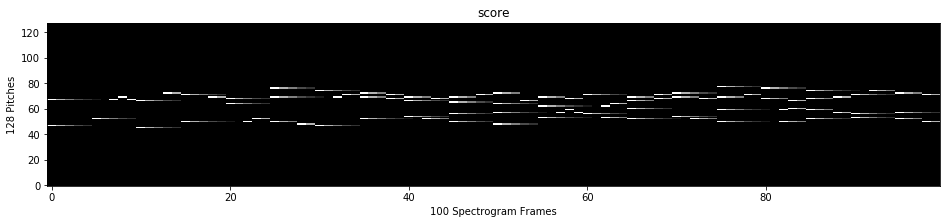

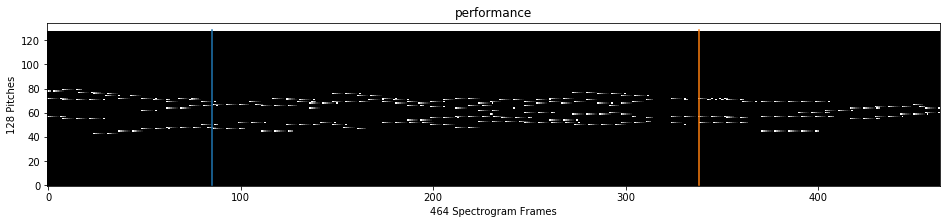

 50%|█████     | 5/10 [00:02<00:02,  2.06it/s]

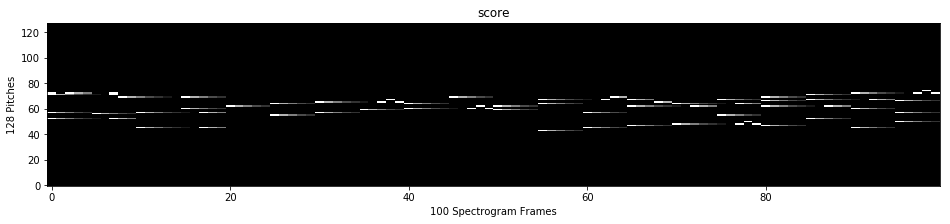

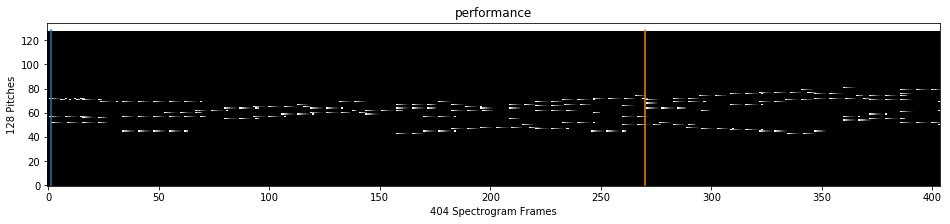

 60%|██████    | 6/10 [00:03<00:01,  2.12it/s]

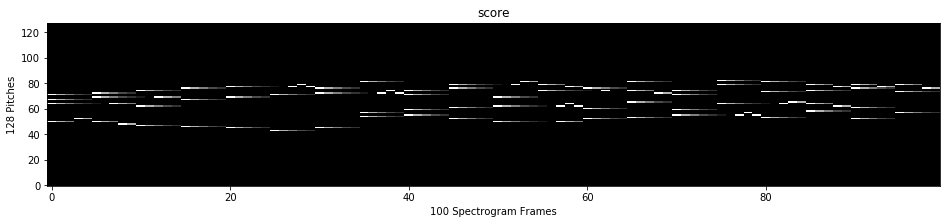

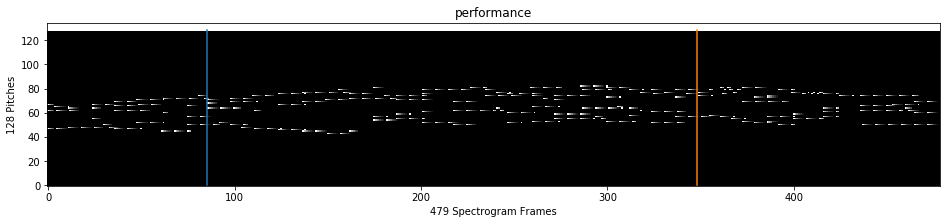

 70%|███████   | 7/10 [00:03<00:01,  2.14it/s]

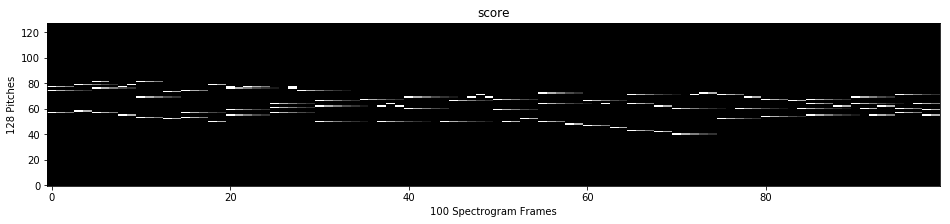

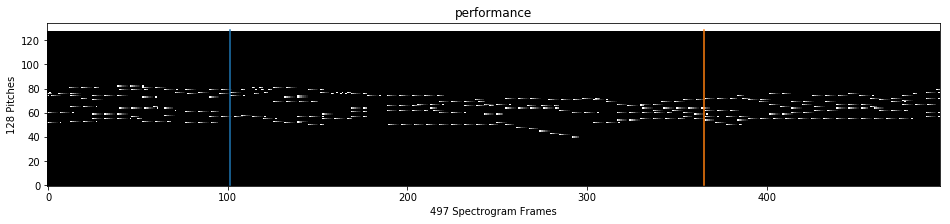

 80%|████████  | 8/10 [00:03<00:00,  2.14it/s]

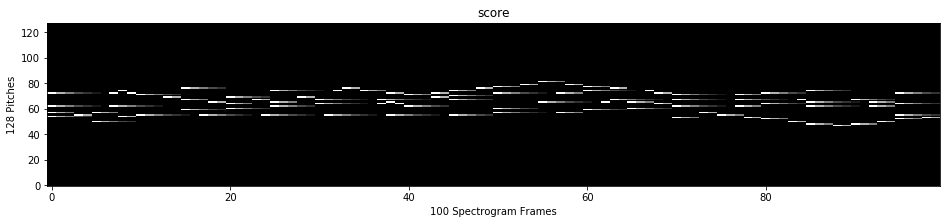

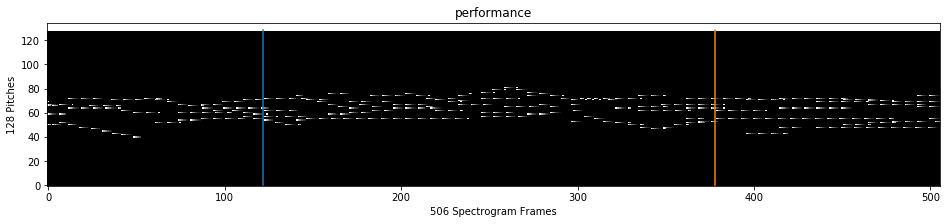

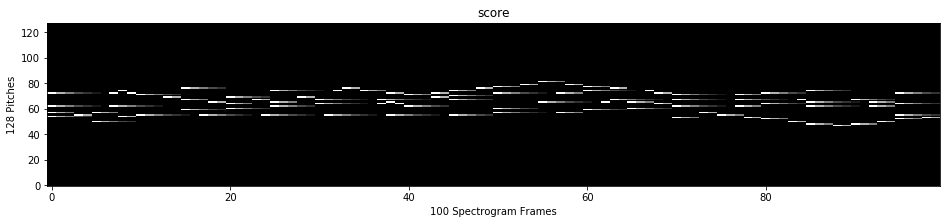

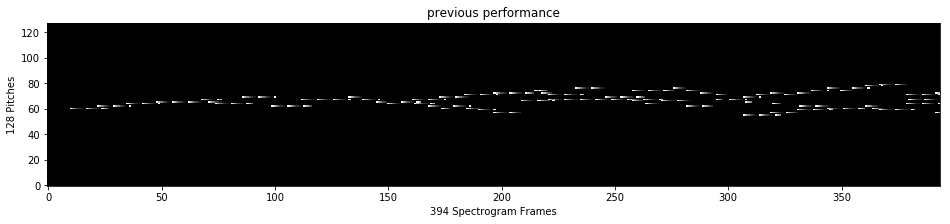

 90%|█████████ | 9/10 [00:04<00:00,  1.70it/s]

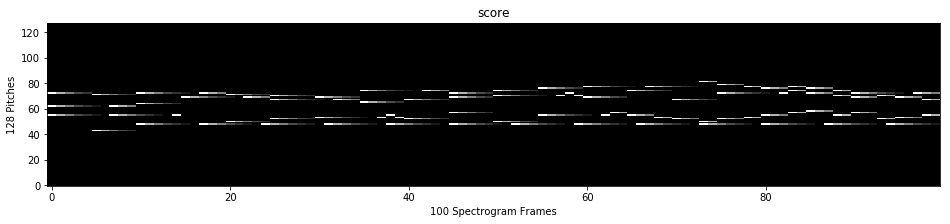

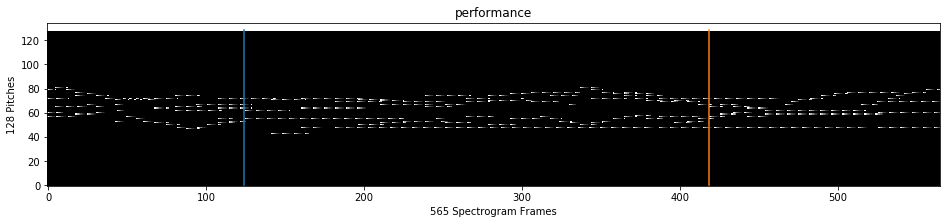

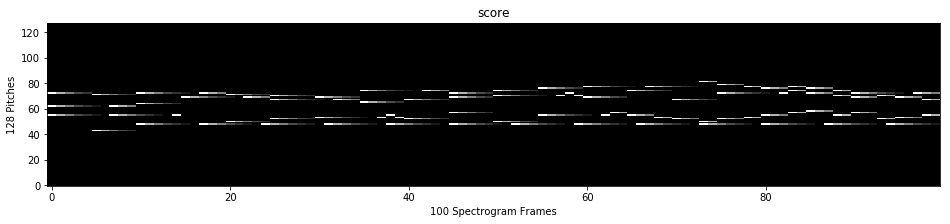

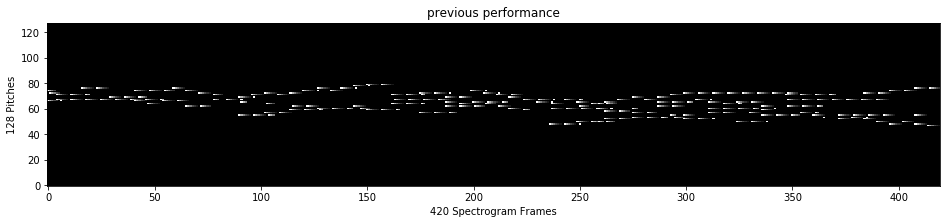

100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


In [6]:
gen = dataset_loader.spawn(dataset_root=ROOT_PATH, slice_duration=SLICE_DURATION, expansion_rate=EXPANSION_RATE, shuffle=True)

prev_perfs = [None] * QUEUE_SIZE
for idx in tqdm(range(NUM_SAMPLES)):
    score, perf, (head, tail) = gen.__next__()

    process_decay(score)
    process_decay(perf)

    plot_matrix("score", score)
    plot_matrix("performance", perf, head, tail)
    
    if isinstance(prev_perfs[0], np.ndarray):
        prev_perf = prev_perfs[0]
        plot_matrix("score", score)
        plot_matrix("previous performance", prev_perf)
    prev_perfs.pop(0)
    prev_perfs.append(perf)